In [32]:
%reload_ext autoreload
%autoreload 2
import torch 
from torch import nn
from torch.nn import functional as F
import math
import sys
import os
import random
sys.path.append('../../pytools')
import d2l
d2l.set_gpu_device()

CUDA 可用，并且显存按需增长已启用。


In [33]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

In [34]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X

In [35]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

In [36]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [37]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

In [38]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [39]:
# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

In [40]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

In [41]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
DenseBlock output shape:	 torch.Size([1, 192, 24, 24])
Sequential output shape:	 torch.Size([1, 96, 12, 12])
DenseBlock output shape:	 torch.Size([1, 224, 12, 12])
Sequential output shape:	 torch.Size([1, 112, 6, 6])
DenseBlock output shape:	 torch.Size([1, 240, 6, 6])
Sequential output shape:	 torch.Size([1, 120, 3, 3])
DenseBlock output shape:	 torch.Size([1, 248, 3, 3])
BatchNorm2d output shape:	 torch.Size([1, 248, 3, 3])
ReLU output shape:	 torch.Size([1, 248, 3, 3])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 248, 1, 1])
Flatten output shape:	 torch.Size([1, 248])
Linear output shape:	 torch.Size([1, 10])


loss 0.140, train acc 0.949, test acc 0.756
1911.1 examples/sec on cuda:0


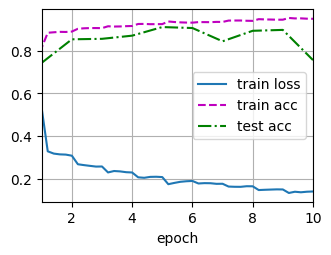

In [42]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [43]:
d2l.print_model_parameters(net)

Layer Name		Variable Name		Parameter Count
Sequential 	Parameter Count:	 3328
DenseBlock 	Parameter Count:	 130048
Sequential 	Parameter Count:	 18912
DenseBlock 	Parameter Count:	 167168
Sequential 	Parameter Count:	 25648
DenseBlock 	Parameter Count:	 185728
Sequential 	Parameter Count:	 29400
DenseBlock 	Parameter Count:	 195008
BatchNorm2d 	Parameter Count:	 496
ReLU 	Parameter Count:	 0
AdaptiveAvgPool2d 	Parameter Count:	 0
Flatten 	Parameter Count:	 0
Linear 	Parameter Count:	 2490
总参数量: 758226
